<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Talleres/Taller%203/MINE4210_ADL2024_Taller3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

# **Taller 3**

- **Integrante 1:**
- **Integrante 2:**

La universidad de los Andes ha evidenciado que nos es ajena a la situación presentada por inteligencia artificial. Chat GPT ha tomado fuerza en los últimos años y su uso ético viene generando preocupación, no sólo para la Universidad, sino para la comunidad académica en general.

Por esta razón, mediante la red Social X, fue generado el debate de las implicaciones de Chat GPT no sólo en el ámbito académico, sino en la vida diaria.

Como un **primer** ejercicio de acercamiento para la percepción de la comunidad en redes sociales, ha sido etiquetada la información acerca de de las opiniones, catalogando como un análisis de polaridad o de sentimientos, clasificando la información como positivo, negativo o neutro. De esta forma fueron presentados los primeros resultados con el modelo base, junto con la ayuda de Glove.

Ahora bien, como **nuevo objetivo** tomaremos los modelos presentados y realizaremos los ajustes necesarios en la búsqueda de mejores resultados.

De esta forma la Universidad tomará esta información como punto de partida para evaluación de acciones a futuro.

Toda la información ha sido consolidada en el siguiente [enlace](https://www.kaggle.com/datasets/evilspirit05/tweet-gpt).

# **Preguntas:**

1.   Construir una red neuronal optimizada para el modelo base con los ajustes que considere necesarios en el procesamiento de la información y/o arquitectura de la red.

2. Construir una red neuronal optimizada apoyada con Glove con los ajustes que considere necesarios en el procesamiento de la información y/o arquitectura de la red.

3.  Realizar la búsqueda de hiperparámetros para ambos casos.

4. Generar una tabla comparativa de los resultados obtenidos.

In [3]:
!pip install kaggle -q
!pip install keras_tuner
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


In [6]:
!pip install tensorflow
!pip install tensorflow_text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 83.2 MB/s eta 0:00:00


In [7]:

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Flatten
from transformers import TFBertForSequenceClassification, BertTokenizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

print('Tensorflow version:', tf.__version__)

import os
import shutil
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')


Tensorflow version: 2.17.0


## Carga y exploración de datos

In [9]:
!ls -lha kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 74 Oct 28 15:13 kaggle.json


In [10]:
!kaggle datasets download evilspirit05/tweet-gpt

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/tweet-gpt
License(s): MIT
 73% 7.00M/9.54M [00:00<00:00, 73.0MB/s]
100% 9.54M/9.54M [00:00<00:00, 74.5MB/s]


In [11]:
DATASET_NAME = 'tweet-gpt'
ROOT_DIR = '/content'


In [12]:
print(f"!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}")

!unzip tweet-gpt.zip -d /content/tweet-gpt


In [13]:
%cd {ROOT_DIR}
!mkdir /{DATASET_NAME}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  tweet-gpt.zip
  inflating: /content/tweet-gpt/tweet_gpt.csv  


In [18]:
data = pd.read_csv(f'{ROOT_DIR}/{DATASET_NAME}/tweet_gpt.csv')
data

,Date,Tweet,Url,User,UserCreated,UserVerified,UserFollowers,UserFriends,Retweets,Likes,...,New_Date,Time,Hour,Day,TweetStr,hashtags,clean_tweet,sentiment_label,sentiment_score,sentiment
0,2023-04-08 03:31:08+00:00,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,https://twitter.com/tubeblogger/status/1644543...,tubeblogger,2013-06-25 01:42:59+00:00,False,312.0,293.0,0.0,0,...,2023-04-08,03:31:08,3,Saturday,OpenAI’s GPT-4 Just Got Supercharged! #ai #Cha...,"['ai', 'ChatGPT']",openai’s gpt4 just got supercharged!,-,0.917779,positive
1,2023-04-08 03:30:51+00:00,"""Classical art"" is struggling - not changed th...",https://twitter.com/majorradic/status/16445432...,majorradic,2011-12-12 01:29:15+00:00,False,522.0,684.0,0.0,2,...,2023-04-08,03:30:51,3,Saturday,"""Classical art"" is struggling - not changed th...","['ChatGPT', 'chatgpt3', 'AIArtwork', 'AI', 'AI...","classical art"" is struggling not changed the ...",-,0.515711,neutral
2,2023-04-08 03:30:00+00:00,Alibaba invites businesses to trial 'ChatGPT r...,https://twitter.com/gadgetsnow/status/16445430...,gadgetsnow,2010-07-29 10:32:28+00:00,True,90392.0,56.0,0.0,0,...,2023-04-08,03:30:00,3,Saturday,Alibaba invites businesses to trial 'ChatGPT r...,"['Alibaba', 'ChatGPT']",alibaba invites businesses to trial chatgpt ri...,-,0.924410,neutral
3,2023-04-08 03:28:59+00:00,Trying to stop students from using #AI and #ch...,https://twitter.com/Sherab_Taye/status/1644542...,Sherab_Taye,2010-05-10 12:40:40+00:00,False,338.0,53.0,0.0,0,...,2023-04-08,03:28:59,3,Saturday,Trying to stop students from using #AI and #ch...,"['AI', 'chatGPT']",trying to stop students from using and is like...,-,0.636237,negative
4,2023-04-08 03:28:31+00:00,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,https://twitter.com/cryptoccentral/status/1644...,cryptoccentral,2023-01-27 00:12:12+00:00,False,1.0,2.0,0.0,2,...,2023-04-08,03:28:31,3,Saturday,I Asked ChatGPT's AI Chatbot How Can I Earn Cr...,"['crypto', 'bitcoin', 'cryptocurrency', 'ai', ...",i asked chatgpts ai chatbot how can i earn cry...,-,0.916693,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37455,2023-03-27 19:39:15+00:00,@IntuitMachine @ylecun Could be true if #ChatG...,https://twitter.com/Astro_Erik/status/16404383...,Astro_Erik,2008-07-20 18:26:07+00:00,False,1908.0,1993.0,0.0,2,...,2023-03-27,19:39:15,19,Monday,@IntuitMachine @ylecun Could be true if #ChatG...,['ChatGPT'],could be true if didnt do plugins.,-,0.733225,neutral
37456,2023-03-27 19:38:27+00:00,It's not so bad anymore that I'm terrible with...,https://twitter.com/pmcruz/status/164043815044...,pmcruz,2009-01-25 19:10:09+00:00,False,1524.0,337.0,0.0,0,...,2023-03-27,19:38:27,19,Monday,It's not so bad anymore that I'm terrible with...,['ChatGPT'],its not so bad anymore that im terrible with r...,-,0.568248,negative
37457,2023-03-27 19:38:16+00:00,Geometric comprehension on\n#ChatGPT #AI https...,https://twitter.com/LuyandaDhlamini/status/164...,LuyandaDhlamini,2017-03-19 18:59:23+00:00,False,672.0,3005.0,0.0,0,...,2023-03-27,19:38:16,19,Monday,Geometric comprehension on\n#ChatGPT #AI https...,"['ChatGPT', 'AI']",geometric comprehension on,-,0.833949,neutral
37458,2023-03-27 19:37:57+00:00,I am having a conversation with @chatgptandai ...,https://twitter.com/ShanaKlank/status/16404380...,ShanaKlank,2014-03-25 20:19:27+00:00,False,83.0,75.0,0.0,0,...,2023-03-27,19:37:57,19,Monday,I am having a conversation with @chatgptandai ...,"['chatgpt', 'riseoftheAI']",i am having a conversation with about the diff...,-,0.624016,neutral


In [22]:

unique_sentiments = data['sentiment'].unique()

for sentiment in unique_sentiments:
    row = data[data['sentiment'] == sentiment].iloc[0]  # Obtener la primera fila con el valor de sentimiento específico
    print("Sentiment:", sentiment)
    print("Tweet:", row['TweetStr'])
    print()


Sentiment: positive
Tweet: OpenAI’s GPT-4 Just Got Supercharged! #ai #ChatGPT  https://t.co/RgMkZlYuRn

Sentiment: neutral
Tweet: "Classical art" is struggling - not changed the fact that is disappearing.

ARTofficial:
It is important that 1/100 passes.
Thousands and thousands will be made.

#ChatGPT #chatgpt3
#AIArtwork #AI #AIPAD
#NFT #Web3 #chatgpt4 #nftarti̇st #AIart #nftart
#NFTJapan #Bing #BingAI

Sentiment: negative
Tweet: Trying to stop students from using #AI and #chatGPT is like trying to stop them from using internet in the early 90s.



In [24]:
data["sentiment"].value_counts()


,count
sentiment,
neutral,19218
positive,11705
negative,6537


In [27]:

label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

etiquetas_unicas = label_encoder.classes_
for valor_numerico, etiqueta_original in enumerate(etiquetas_unicas):
    print(f'Valor numérico: {valor_numerico}, Etiqueta original: {etiqueta_original}')

Valor numérico: 0, Etiqueta original: negative
Valor numérico: 1, Etiqueta original: neutral
Valor numérico: 2, Etiqueta original: positive


In [30]:
columns = ['sentiment','clean_tweet']
data_columns = data[columns]


In [32]:
data_columns.sample(5)

,sentiment,clean_tweet
27652,2,i am here to announce that is the best tool to...
33010,1,"“over the next few months and years, we can ex..."
25715,1,here are five critical priorities for cios bec...
20478,2,my assistant is so funny. its very best websit...
36028,2,part of the gang now. just subd and can feel t...


In [35]:

# Divide los datos en entrenamiento y prueba
train, test = train_test_split(data_columns, test_size=0.2, stratify=data_columns['sentiment'], random_state=42, shuffle = True)

# Ahora divide el conjunto de entrenamiento en entrenamiento y validación
train, val = train_test_split(train, test_size=0.2, stratify=train['sentiment'], random_state=42, shuffle = True)

print("Tamaño de datos de entrenamiento:", train.shape)
print("Tamaño de datos de validación:", val.shape)
print("Tamaño de datos de prueba:", test.shape)

train

Tamaño de datos de entrenamiento: (23974, 2)
Tamaño de datos de validación: (5994, 2)
Tamaño de datos de prueba: (7492, 2)


,sentiment,clean_tweet
8010,0,every generation mistakenly thinks theirs will...
30863,2,"introducing the innovative project, where owni..."
21970,2,italy bans interesting move!
15743,0,"heres another learning angle, this time having..."
8006,2,wow! its been a week and ive never felt safer ...
...,...,...
32711,0,the basic truth behind &amp; is that it’s unre...
23463,2,thats going to be interesting.
34292,1,indian version of chatgpt to be announced soon...
3502,0,and you still dare to offer a paid service? wh...


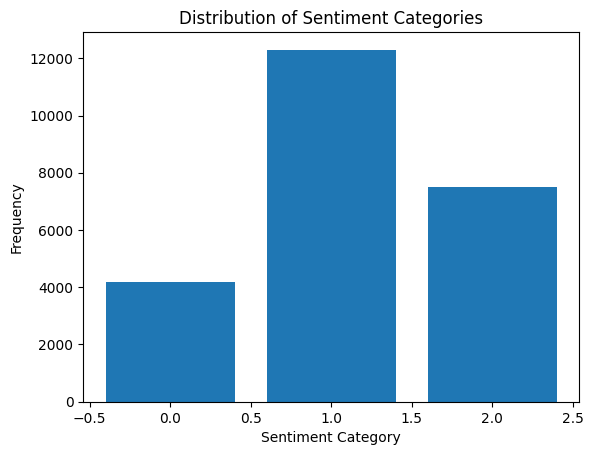

In [36]:

# Create a bar plot to visualize the distribution
unique, counts = np.unique(train['sentiment'], return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Categories')
plt.show()


In [37]:

X_train, X_test, X_val= train['clean_tweet'], test['clean_tweet'], val['clean_tweet']
y_train, y_test, y_val= train['sentiment'], test['sentiment'], val['sentiment']

print("x_train", X_train.shape, " y_train:", y_train.shape)
print("x_test:", X_test.shape, "y_test", y_test.shape)
print("x_val", X_val.shape, "y_val:", y_val.shape)

X_train


x_train (23974,)  y_train: (23974,)
x_test: (7492,) y_test (7492,)
x_val (5994,) y_val: (5994,)


,clean_tweet
8010,every generation mistakenly thinks theirs will...
30863,"introducing the innovative project, where owni..."
21970,italy bans interesting move!
15743,"heres another learning angle, this time having..."
8006,wow! its been a week and ive never felt safer ...
...,...
32711,the basic truth behind &amp; is that it’s unre...
23463,thats going to be interesting.
34292,indian version of chatgpt to be announced soon...
3502,and you still dare to offer a paid service? wh...


## Download GloVe embedding

In [8]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-10-28 15:09:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.06MB/s    in 2m 39s  

2024-10-28 15:12:19 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [14]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [15]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

NameError: name 'voc' is not defined

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

# **Notas Importantes:**
- El proceso propuesto debe estar debidamente codificado y justificado en cada una de las decisiones tomadas.
- La propuesta realizada es propia de cada grupo, no deben generarse procesos iguales con otros grupos de trabajo.
- No es necesario repetir el código implementado en la primera versión, debes trabajar en las mejoras/optimizaciones específicamente.
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `Taller_3_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.